# Data Loading

In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl

In [2]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [3]:
BATCH_SIZE = 10_000

In [4]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["solved", "interrupted"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(["solved", "interrupted"])

Found 710800 files belonging to 2 classes.
Using 568640 files for training.


2023-11-01 12:51:53.319189: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-01 12:51:53.319224: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-01 12:51:53.319228: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-01 12:51:53.319469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-01 12:51:53.319837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 710800 files belonging to 2 classes.
Using 142160 files for validation.


In [5]:
for X,y in train_dataset.take(1):
    pass

In [6]:
XX = X

In [7]:
y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
y = y == 1

In [8]:
print(X.numpy().astype(str)[0])

dataset: X
instance: MA3
+-----------+
2D Packing MIP with Time Limit 7.146542368867182 [s] in Truck P187130303
Stack 0 with items: ['0090016200_08062023028155', '0090016200_08062023028155', '0090016200_08062023028155']
Stack 1 with items: ['0090016200_08062023028155', '0090016200_08062023028155', '0090016200_08062023028155']
Stack 2 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 3 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 4 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 5 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 6 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 7 with items: ['0090016200_08062023008369', '0090016200_08062023003507', '0090016200_08062023003507']
Stack 8 with items: ['00

In [9]:
X = X.numpy().astype(str)
df = pl.DataFrame({"raw": X})
print(df[0, 0])

dataset: X
instance: MA3
+-----------+
2D Packing MIP with Time Limit 7.146542368867182 [s] in Truck P187130303
Stack 0 with items: ['0090016200_08062023028155', '0090016200_08062023028155', '0090016200_08062023028155']
Stack 1 with items: ['0090016200_08062023028155', '0090016200_08062023028155', '0090016200_08062023028155']
Stack 2 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 3 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 4 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 5 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 6 with items: ['0090016200_08062023014973', '0090016200_08062023014973', '0090016200_08062023014973']
Stack 7 with items: ['0090016200_08062023008369', '0090016200_08062023003507', '0090016200_08062023003507']
Stack 8 with items: ['00

# Processing functions:

## Extract raw data

In [10]:
def extract_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extracts features via regex from raw txt-file input.
    Drops rows which dont contain a truck_id or 3D packing instances
    """
    df = df.with_columns([
        pl.Series(name="index", values=np.arange(len(df.collect()))),
        #pl.Series(name="index", values=np.arange(len(df))),
        pl.col("raw").str.extract("in Truck (\w\d{9})\n").alias("truck_id"),
        pl.col("raw").str.extract("dataset: (\w*)\n").alias("dataset"),
        pl.col("raw").str.extract("instance: ([A-Z0-9]*)\n").alias("instance"),
    ])
    
    return df


In [11]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .collect()
    .head()
)

raw,index,truck_id,dataset,instance
str,i64,str,str,str
"""dataset: X ins…",0,"""P187130303""","""X""","""MA3"""
"""dataset: C ins…",1,"""P103412701""","""C""","""CI"""
"""dataset: X ins…",2,"""P191156225""","""X""","""SA6"""
"""dataset: X ins…",3,"""P185520301""","""X""","""FS"""
"""dataset: X ins…",4,"""P198038103""","""X""","""MA5"""


## Explode instance into stacks:

In [12]:
def explode_instances_into_stacks(df: pl.LazyFrame) -> pl.DataFrame:
    """
    Use regex to extract all stacks made of item ids, and explode df
    into rows of stacks, belonging to an instance.
    """
    
    df = (
        df.with_columns([
            pl.col("raw").str.extract_all("Stack \d* with items: (\[.*\])\n").alias("stacks")
        ])
          .drop(["raw"])
          .explode(columns = ["stacks"])\
          .with_columns([
              pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
              pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
          ])
    )
    return df


In [13]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stacks,stack_id,item_id
i64,str,str,str,str,i64,list[str]
0,"""P187130303""","""X""","""MA3""","""Stack 0 with i…",0,"[""0090016200_08062023028155"", ""0090016200_08062023028155"", ""0090016200_08062023028155""]"
0,"""P187130303""","""X""","""MA3""","""Stack 1 with i…",1,"[""0090016200_08062023028155"", ""0090016200_08062023028155"", ""0090016200_08062023028155""]"
0,"""P187130303""","""X""","""MA3""","""Stack 2 with i…",2,"[""0090016200_08062023014973"", ""0090016200_08062023014973"", ""0090016200_08062023014973""]"
0,"""P187130303""","""X""","""MA3""","""Stack 3 with i…",3,"[""0090016200_08062023014973"", ""0090016200_08062023014973"", ""0090016200_08062023014973""]"
0,"""P187130303""","""X""","""MA3""","""Stack 4 with i…",4,"[""0090016200_08062023014973"", ""0090016200_08062023014973"", ""0090016200_08062023014973""]"


## Explode stacks into items:

In [14]:
def explode_stacks_into_items(df: pl.DataFrame) -> pl.DataFrame:
    """
    Use regex to identify a stack and explode it into items,
    belonging to a stack, which again belongs to an instance.
    """
    df = df.with_columns([
        pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
        pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
    ]).drop("stacks").explode("item_id")\
    
    return df

In [15]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .collect()
    #.head()
)

index,truck_id,dataset,instance,stack_id,item_id
i64,str,str,str,i64,str
0,"""P187130303""","""X""","""MA3""",0,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",0,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",0,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",1,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",1,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",1,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",2,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",2,"""0090016200_080…"
0,"""P187130303""","""X""","""MA3""",2,"""0090016200_080…"


## Load and Merge Items

In [16]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
27029901,null,90016900,"""169GD-60""","""769150009R""","""SFDA--6608""",1.6,1.2,0.93,0.17098,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
23676300,null,90016900,"""169GD-60""","""625000232R""","""ECM---5136""",2.4,2.2,1.52,0.5944,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.475
24099001,null,90016900,"""169GB-30""","""791A20004R""","""CON-S-0130""",0.78,0.57,0.478,0.0819,0.047,"""C""","""BY""","""0090016900_270…",false,true,0.431
1925700,null,90016900,"""GRF1""","""684305630R""","""KFDA--0047""",1.209,1.007,0.75,0.120524,0.025,"""C""","""BY""","""0090016900_270…",false,false,0.725
201500,null,90016900,"""169GD-60""","""792767297R""","""ECM---6693""",2.0,1.34,1.13,0.15804,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.085


In [17]:
def join_items(df: pl.DataFrame, items) -> pl.DataFrame:
    """
    Perform a simple left join to add item level info.
    
    Validation sadly not supported for multiple keys (yet?)
    """
    
    return df.join(items, how = "left", on = ["dataset", "instance", "item_id"])

In [18]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stack_id,item_id,Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,ForcedLength,ForcedWidth,NestedHeight
i64,str,str,str,i64,str,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,bool,bool,f64
0,"""P187130303""","""X""","""MA3""",0,"""0090016200_080…",90016100,"""G16""",90016200,"""G024G1""","""290035376R""","""CFDA--3011""",2.28,1.47,0.885,1.132,0.045,false,false,0.84
0,"""P187130303""","""X""","""MA3""",0,"""0090016200_080…",90016100,"""G16""",90016200,"""G024G1""","""290035376R""","""CFDA--3011""",2.28,1.47,0.885,1.132,0.045,false,false,0.84
0,"""P187130303""","""X""","""MA3""",0,"""0090016200_080…",90016100,"""G16""",90016200,"""G024G1""","""290035376R""","""CFDA--3011""",2.28,1.47,0.885,1.132,0.045,false,false,0.84
0,"""P187130303""","""X""","""MA3""",1,"""0090016200_080…",90016100,"""G16""",90016200,"""G024G1""","""290035376R""","""CFDA--3011""",2.28,1.47,0.885,1.132,0.045,false,false,0.84
0,"""P187130303""","""X""","""MA3""",1,"""0090016200_080…",90016100,"""G16""",90016200,"""G024G1""","""290035376R""","""CFDA--3011""",2.28,1.47,0.885,1.132,0.045,false,false,0.84


## Group by stack ID:

In [19]:
def group_items_by_stack(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group item level into back into a stack
    
    - Note that the Width and Length are the same for all items
    - Weight and Height have to be summed up, correcting for nesting height
    - forcedOrientation of a single item makes the whole stack oriented
    - Include Logistics info for stop differentation down the road
    
    """
    
    df = df.group_by(["index", "dataset", "instance", "truck_id", "stack_id"],
                    maintain_order = True)\
    .agg([
        pl.count("item_id").alias("items"),
        pl.max("Length"),
        pl.max("Width"),
        pl.sum("NestedHeight"),
        pl.last("Nesting height"),
        pl.sum("Weight"),
        pl.any("ForcedLength"),
        pl.any("ForcedWidth"),
        # Logistic order info
        pl.first("Supplier code"),
        pl.first("Supplier dock"),
        pl.first("Plant dock")
    ]).sort(["index", "stack_id"]).drop(["stack_id"])

    return df

In [20]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
# (507_770, 7)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,1.2,1.0,2.115,0.045,0.80184,false,false,90016100,"""G16""","""G024G1"""


## Data Vis:

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",
        style="darkgrid")

In [22]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,90016100,"""G16""","""G024G1"""
0,"""X""","""MA3""","""P187130303""",3,1.2,1.0,2.115,0.045,0.80184,false,false,90016100,"""G16""","""G024G1"""


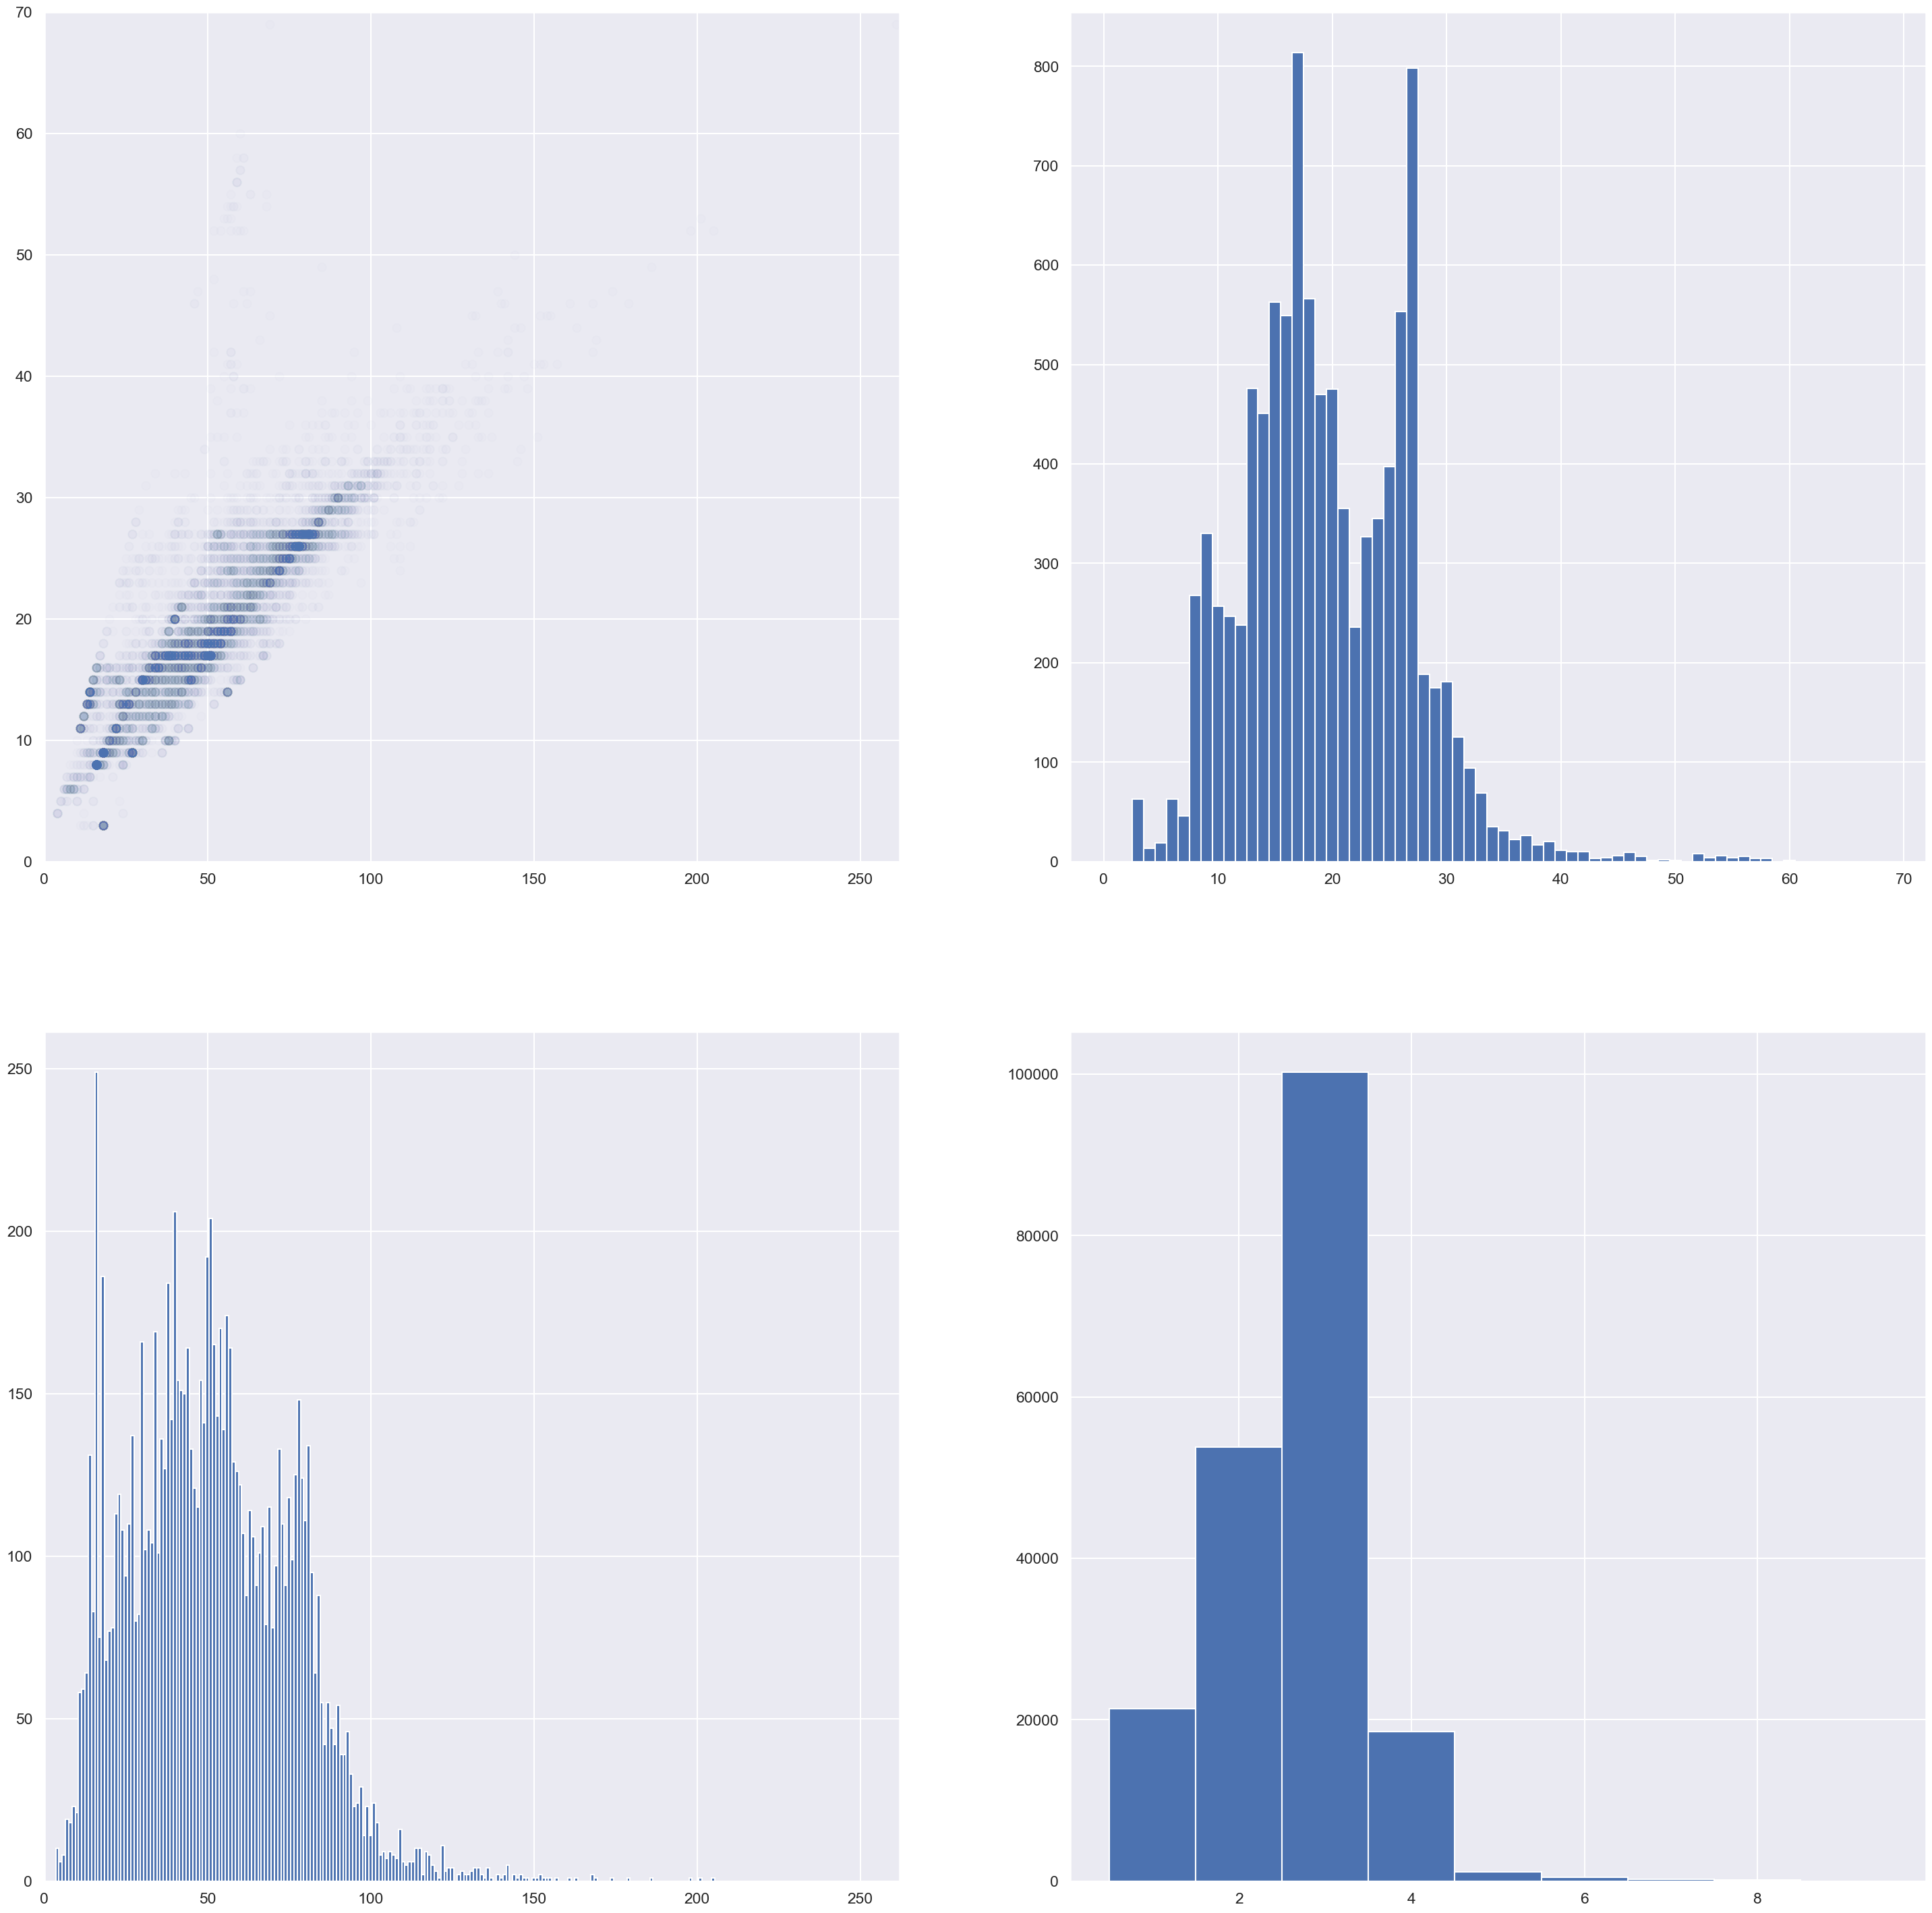

In [23]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

item_max = x.max()[0, "total_items"]
stack_max = x.max()[0, "total_stacks"]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))



ax[0, 0].scatter(
    y=x["total_stacks"],
    x=x["total_items"],
    #c = y.numpy(),
    alpha = 0.01
);
ax[0, 0].set(xlim=[0, item_max+1])
ax[0, 0].set(ylim=[0, stack_max+1])

ax[0, 1].hist(x["total_stacks"], bins=np.arange(0, stack_max, 1)+0.5)

ax[1, 0].hist(x["total_items"], bins=np.arange(0, item_max, 1)+0.5)
ax[1, 0].set(xlim=[0, item_max+1])



x = X["items"].to_numpy()
ax[1, 1].hist(x, bins=np.arange(0, 10, 1)+0.5);


In [24]:
import plotly.express as px

# https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

px.scatter(
    x,
    y="total_stacks",
    x="total_items",
    opacity = 0.1
)

## Merge Loading order

In [25]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730405""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730407""","""A""","""AS"""


In [26]:
def join_truck_loading_order(df: pl.DataFrame, truck_stops) -> pl.DataFrame:
    """
    Extract the loading orders in the truck_stops
    from the supplier and plant order, given by the stacks/items
    
    TODO:
    -----
    
    - Include a check whether the last item in a stack is different from the first
        This would mean that it is a multistack, making the problem much more difficult
        Jakob said this is often explicitly forbidden by the heuristic, and rarely the 
        case anyways.
    """
    
    truck_join_clms = ["truck_id", "dataset", "instance",
                       "Supplier code", "Supplier dock", "Plant dock"]
    truck_info_clms = ["Supplier loading order",
                       "Supplier dock loading order",
                       "Plant dock loading order"]
    
    df = df.join(truck_stops, how = "left", on = truck_join_clms )
    
    df = df.with_columns([
        pl.concat_str(pl.col(truck_info_clms), separator = "-").alias("packing_order")
    ])
    
    df = df.drop(truck_join_clms[-3:]
                 + truck_info_clms
    )
    
    return df
    

In [27]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .collect()
    #.head()
)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,packing_order
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,str
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,2.28,1.47,2.52,0.045,3.396,false,false,"""1-1-1"""
0,"""X""","""MA3""","""P187130303""",3,1.2,1.0,2.115,0.045,0.80184,false,false,"""1-1-1"""


# Tabular Data for ML

## load and Join truck info

In [28]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Width", "Length", "Max weight"
             ]

new_clm_names = {"Width": "TruckWidth",
                 "Length": "TruckLength",
                 "Max weight": "TruckWeight"}

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .rename(new_clm_names)
    .unique()
    .sort(["dataset", "instance", "truck_id"])
)

truck_dims = truck_dims.with_columns([
    (pl.col("TruckLength") / 1000),
    (pl.col("TruckWidth") / 1000),
    (pl.col("TruckWeight") / 1000),
    (pl.col("dataset").str.extract("([A-Z])")),
])

truck_dims.collect()

truck_id,TruckLength,TruckWidth,TruckWeight,dataset,instance
str,f64,f64,f64,str,str
"""P187721701""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730401""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730403""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730405""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730407""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730501""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730503""",14.94,2.5,24.0,"""A""","""AS"""
"""P187731001""",14.94,2.5,24.0,"""A""","""AS"""
"""P187731005""",14.94,2.5,24.0,"""A""","""AS"""


In [29]:
def normalize_stacks_by_truck(df: pl.DataFrame, truck_dims: pl.LazyFrame) -> pl.DataFrame:
    """
    Update the 'ForcedLength' column to include implicit cases.
    
    Calculated Length and Width Remainders
    
    Explicit cases are those where the Orienteation is directly forced.
    Implicit cases are those where the length is greater than the truck width,
    forcing the orientaiton to be lengthwise.
    
    Requires Truck info
    """
    
    df = df.join(truck_dims, how = "left", on = ["truck_id", "dataset", "instance"])
    
    df = df.with_columns([
        # Inplicitly forced by Length
        #(pl.col("ForcedLength") | pl.col("Length") > pl.col("TruckWidth")).alias("ForcedLength"),
        (pl.col("TruckWidth") % pl.col("Length")).alias("LengthRemainder"),
        (pl.col("TruckWidth") % pl.col("Width")).alias("WidthRemainder"),
    ])
    
    
    # relevant columns
    clms = df.head().collect().columns
    truck_clms = [clm for clm in truck_dims.columns if clm[0].isupper()]
    
    # divide stack dimension by corresponding truck dimension
    df = df.with_columns([
        (pl.col(clm) / pl.col(truck_clm))
        for clm in clms 
        for truck_clm in truck_clms  
        if (clm in truck_clm) and (clm != truck_clm)
        #and ("Forced" not in clm)
    ])
    
    # Length Remainder has been divided by the Truck Length, but must be divided by the truck width!
    df = df.with_columns([
        (pl.col("LengthRemainder") * pl.col("Length") / pl.col("Width")).alias("LengthRemainder")
    ])

    # calculate Area as proportion of Truck:
    df = df.with_columns([
        (pl.col("Length") * pl.col("Width")).alias("Area")
    ])
    
    df = df.drop(truck_clms)

    return df


In [30]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .collect()
    #.head()
)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,packing_order,LengthRemainder,WidthRemainder,Area
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,str,f64,f64,f64
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.168889,0.602459,2.52,0.045,0.121286,false,false,"""1-1-1""",0.044853,0.97,0.101749
0,"""X""","""MA3""","""P187130303""",3,0.088889,0.409836,2.115,0.045,0.028637,false,false,"""1-1-1""",0.008676,0.44,0.03643


### Visualization of normalized stack info:

In [31]:
def select_numeric_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    """
    Filter Function to only select numeric columns
    """

    NUMERIC_POLARS_DTYPES = [
        pl.Int8, pl.Int16, pl.Int32, pl.Int64, 
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64,
        pl.Boolean
    ]
    
    df = df.select([
        pl.col(NUMERIC_POLARS_DTYPES).cast(pl.Float64)
    ])
    
    return df


In [32]:
corr = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(select_numeric_dtypes)
    .collect()
    .corr()
    #.head()
)

px.imshow(corr, y = corr.columns, aspect="auto")

## Aggregate Stacks by Instance

In [33]:
def group_stacks_by_instance(df: pl.DataFrame, sort = False) -> pl.DataFrame:
    """
    Aggregate stack info back into features of a single instance.
    """
    
    # could be extended for more features, eg pl.median and "Density"
    agg_funcs = [
        #pl.min,
        pl.mean,
        pl.max,
        pl.var, 
        #pl.n_unique
    ]
    clms = ["Length", "Width", "Area", "Weight", "LengthRemainder", "WidthRemainder"]
    

    df = df.group_by(["dataset", "instance", "truck_id", "index"])\
    .agg([
        pl.col("index").count().alias("stacks"),
        pl.sum("items"),
        pl.sum("Area").alias("TotalArea"),
        pl.sum("Weight").alias("TotalWeight"),
        #pl.max("items").alias("max_stack_items"),
        #pl.std("items").alias("std_stack_items"),
        pl.mean("ForcedLength"),
        pl.mean("ForcedWidth"),
        pl.n_unique("packing_order").alias("stops"),
        # Truck Features:
        #pl.mean("TruckLength"),
        #pl.mean("TruckWidth"),
        #pl.mean("TruckWeight"),
    ]+[
        func(clm).alias("_".join([clm, func.__name__]))
        for func in agg_funcs 
        for clm in clms
    ]).drop(["Weight_mean", "Area_mean"])
    
    if sort:
        df = df.sort(["index"])
    
    return df
    

In [34]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(group_stacks_by_instance)
    .collect()
    #.head()
)

dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,stops,Length_mean,Width_mean,LengthRemainder_mean,WidthRemainder_mean,Length_max,Width_max,Area_max,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var
str,str,str,i64,u32,u32,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C""","""BY""","""P069065911""",12,17,57,0.979964,0.380604,0.0,0.0,1,0.118083,0.486982,0.188215,0.063529,0.140741,0.491803,0.069217,0.027652,0.20243,0.44,0.000086,0.000395,0.000037,0.000014,0.002275,0.009412
"""X""","""SA6""","""P186056805""",13,14,15,0.924954,0.5114272,0.0,0.0,1,0.148571,0.442037,0.130715,0.282857,0.162963,0.45082,0.073467,0.04964,0.263159,0.44,0.000631,0.000305,0.000171,0.000026,0.005672,0.007253
"""X""","""TR5""","""P193420403""",16,26,79,0.973471,0.614454,0.192308,0.0,4,0.089778,0.41488,0.031072,0.415385,0.118519,0.491803,0.058288,0.051,0.20243,0.48,0.00008,0.000526,0.00004,0.000174,0.002802,0.012522
"""X""","""RM3""","""P195391303""",18,27,78,0.985251,0.432964,0.0,0.0,1,0.088938,0.410291,0.008383,0.437778,0.089333,0.413934,0.036978,0.019073,0.008676,0.44,2.0260e-8,0.000002,3.0831e-8,0.000008,7.1090e-7,0.000041
"""X""","""BY7""","""P205065711""",20,15,30,0.874317,1.469595,0.0,0.0,1,0.118519,0.491803,0.20243,0.04,0.118519,0.491803,0.058288,0.09804,0.20243,0.04,0.0,0.0,0.0,6.7335e-8,0.0,0.0
"""X""","""MA6""","""P186340901""",32,25,57,0.912392,0.944416,0.0,0.0,4,0.088942,0.410328,0.00836,0.4376,0.089333,0.413934,0.036978,0.047125,0.008676,0.44,2.1728e-8,0.000002,3.3066e-8,0.000196,7.6244e-7,0.000044
"""C""","""RM""","""P091390025""",45,7,9,0.969035,0.130278,0.0,0.0,1,0.182011,0.690867,0.286293,0.097143,0.237037,0.983607,0.233151,0.046608,0.58801,0.44,0.003637,0.075824,0.008157,0.000169,0.084165,0.022857
"""B""","""SA""","""P339234901""",58,24,57,0.875413,0.992064,0.0,0.0,2,0.088926,0.410178,0.008456,0.438333,0.089333,0.413934,0.036978,0.058594,0.008676,0.44,1.5745e-8,0.000001,2.3961e-8,0.000149,5.5249e-7,0.000032
"""X""","""CI2""","""P207447823""",64,23,79,0.994604,0.393159,0.0,0.0,1,0.09811,0.435656,0.066457,0.314,0.118519,0.491803,0.058288,0.024445,0.20243,0.44,0.000191,0.001443,0.000104,0.000041,0.008459,0.034374


### Visualized normalized Truck or Instance Info:

In [35]:
corr = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(group_stacks_by_instance)
    .pipe(select_numeric_dtypes)
    .collect()
    .corr()
    #.head()
)

px.imshow(corr, y = corr.columns, aspect="auto")

## Build an ML model to get a baseline performance

In [36]:
df = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(group_stacks_by_instance)
    .collect()
    .to_pandas()
    #.head()
)

del(items)
del(truck_stops)
del(truck_dims)

df

,dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,...,Area_max,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var
0,C,CI,P103412701,1,31,75,0.908115,0.932453,0.0,0.161290,...,0.058288,0.102987,0.202430,0.44,5.611026e-04,0.011303,3.058188e-04,6.905994e-04,0.005899,0.029725
1,C,SA2,P095050811,7,15,30,0.955011,0.322712,0.0,0.000000,...,0.065574,0.031176,0.173511,0.42,1.290667e-04,0.000404,5.451400e-05,7.144260e-06,0.001870,0.009627
2,X,BY5,P201161111,8,8,16,0.893746,0.966292,0.0,0.000000,...,0.111718,0.120908,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,2.396450e-09,0.000000,0.000000
3,A,PA,P259540201,19,16,53,0.779599,0.407903,0.0,0.562500,...,0.058288,0.033650,0.202430,0.44,2.304527e-04,0.001764,1.254143e-04,1.612579e-05,0.009854,0.042000
4,X,BY7,P205065711,20,15,30,0.874317,1.469595,0.0,0.000000,...,0.058288,0.098040,0.202430,0.04,0.000000e+00,0.000000,0.000000e+00,6.733500e-08,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,C,TR2,P083420101,9950,25,75,0.955011,0.669842,0.0,0.000000,...,0.058288,0.034051,0.202430,0.44,6.722692e-05,0.000514,3.656107e-05,1.313676e-05,0.002882,0.012229
9996,X,BY5,P241161101,9972,12,24,1.340619,1.450892,0.0,0.000000,...,0.111718,0.121046,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,1.742873e-08,0.000000,0.000000
9997,B,VA,P353648603,9977,21,55,0.898938,0.861150,0.0,0.285714,...,0.058288,0.068479,0.202430,0.44,2.790987e-04,0.003478,1.509241e-04,3.132357e-04,0.008790,0.035373
9998,C,MA3,P104228001,9979,22,48,0.804199,0.998663,0.0,0.000000,...,0.036978,0.054317,0.008676,0.44,3.634226e-08,0.000003,5.530511e-08,1.175321e-04,0.000001,0.000074


In [37]:
X = XX.numpy().astype(str)
X = pl.DataFrame({"raw": X})
X

raw
str
"""dataset: X ins…"
"""dataset: C ins…"
"""dataset: X ins…"
"""dataset: X ins…"
"""dataset: X ins…"
"""dataset: A ins…"
"""dataset: X ins…"
"""dataset: C ins…"
"""dataset: X ins…"


In [38]:
y_number_improvements = X["raw"].str.extract_all("MIP Improvement").list.len()
y_improvement = (y_number_improvements > 1)
y_improvement.mean()

0.4719

In [39]:
df["improvemnt"] = y_improvement
df

,dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,...,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var,improvemnt
0,C,CI,P103412701,1,31,75,0.908115,0.932453,0.0,0.161290,...,0.102987,0.202430,0.44,5.611026e-04,0.011303,3.058188e-04,6.905994e-04,0.005899,0.029725,False
1,C,SA2,P095050811,7,15,30,0.955011,0.322712,0.0,0.000000,...,0.031176,0.173511,0.42,1.290667e-04,0.000404,5.451400e-05,7.144260e-06,0.001870,0.009627,False
2,X,BY5,P201161111,8,8,16,0.893746,0.966292,0.0,0.000000,...,0.120908,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,2.396450e-09,0.000000,0.000000,True
3,A,PA,P259540201,19,16,53,0.779599,0.407903,0.0,0.562500,...,0.033650,0.202430,0.44,2.304527e-04,0.001764,1.254143e-04,1.612579e-05,0.009854,0.042000,True
4,X,BY7,P205065711,20,15,30,0.874317,1.469595,0.0,0.000000,...,0.098040,0.202430,0.04,0.000000e+00,0.000000,0.000000e+00,6.733500e-08,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,C,TR2,P083420101,9950,25,75,0.955011,0.669842,0.0,0.000000,...,0.034051,0.202430,0.44,6.722692e-05,0.000514,3.656107e-05,1.313676e-05,0.002882,0.012229,True
9996,X,BY5,P241161101,9972,12,24,1.340619,1.450892,0.0,0.000000,...,0.121046,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,1.742873e-08,0.000000,0.000000,False
9997,B,VA,P353648603,9977,21,55,0.898938,0.861150,0.0,0.285714,...,0.068479,0.202430,0.44,2.790987e-04,0.003478,1.509241e-04,3.132357e-04,0.008790,0.035373,False
9998,C,MA3,P104228001,9979,22,48,0.804199,0.998663,0.0,0.000000,...,0.054317,0.008676,0.44,3.634226e-08,0.000003,5.530511e-08,1.175321e-04,0.000001,0.000074,True


### Visualizations:

In [40]:
px.histogram(x = df["TotalArea"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Total Stack Area",
             }
            )

In [41]:
px.histogram(x = df["TotalWeight"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Total Stack Weight",
             }
            )

In [42]:
px.histogram(x = df["stops"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Total Truck Stops",
             }
            )

In [43]:
px.scatter(x = df["TotalArea"],
           y = df["TotalWeight"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.2,
           labels = {
               "x": "Total Stack Area",
               "y": "Total Stack Weight"
           }
          )

In [44]:
px.scatter(x = df["LengthRemainder_mean"],
           y = df["WidthRemainder_mean"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "LengthRemainder Minimum",
               "y": "WidthRemainder Minimum"
           }
          )

In [45]:
px.scatter(x = df["LengthRemainder_max"],
           y = df["WidthRemainder_max"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "LengthRemainder Maximum",
               "y": "WidthRemainder Maximum"
           },
           #log_x = True, log_y = True
          )

In [46]:
px.scatter(x = df["LengthRemainder_var"]**0.5,
           y = df["WidthRemainder_var"]**0.5,
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "LengthRemainder Standard Deviation",
               "y": "WidthRemainder Standard Deviation"
           },
           #log_x = True, log_y = True
          )

### Preperation

In [47]:
X = df.iloc[:,4:-1].copy()
X

,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,stops,Length_mean,Width_mean,LengthRemainder_mean,...,Area_max,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var
0,31,75,0.908115,0.932453,0.0,0.161290,4,0.079164,0.339767,0.048684,...,0.058288,0.102987,0.202430,0.44,5.611026e-04,0.011303,3.058188e-04,6.905994e-04,0.005899,0.029725
1,15,30,0.955011,0.322712,0.0,0.000000,1,0.130400,0.486612,0.162347,...,0.065574,0.031176,0.173511,0.42,1.290667e-04,0.000404,5.451400e-05,7.144260e-06,0.001870,0.009627
2,8,16,0.893746,0.966292,0.0,0.000000,1,0.170370,0.655738,0.036374,...,0.111718,0.120908,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,2.396450e-09,0.000000,0.000000
3,16,53,0.779599,0.407903,0.0,0.562500,2,0.105556,0.455943,0.117662,...,0.058288,0.033650,0.202430,0.44,2.304527e-04,0.001764,1.254143e-04,1.612579e-05,0.009854,0.042000
4,15,30,0.874317,1.469595,0.0,0.000000,1,0.118519,0.491803,0.202430,...,0.058288,0.098040,0.202430,0.04,0.000000e+00,0.000000,0.000000e+00,6.733500e-08,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,75,0.955011,0.669842,0.0,0.000000,3,0.091277,0.416557,0.024071,...,0.058288,0.034051,0.202430,0.44,6.722692e-05,0.000514,3.656107e-05,1.313676e-05,0.002882,0.012229
9996,12,24,1.340619,1.450892,0.0,0.000000,1,0.170370,0.655738,0.036374,...,0.111718,0.121046,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,1.742873e-08,0.000000,0.000000
9997,21,55,0.898938,0.861150,0.0,0.285714,4,0.097432,0.430133,0.073147,...,0.058288,0.068479,0.202430,0.44,2.790987e-04,0.003478,1.509241e-04,3.132357e-04,0.008790,0.035373
9998,22,48,0.804199,0.998663,0.0,0.000000,2,0.088990,0.410768,0.008077,...,0.036978,0.054317,0.008676,0.44,3.634226e-08,0.000003,5.530511e-08,1.175321e-04,0.000001,0.000074


In [48]:
#y = y.numpy()
#y = y[:,0]
y = y_improvement
round(1-y.mean(), 3)

0.528

In [49]:
X

,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,stops,Length_mean,Width_mean,LengthRemainder_mean,...,Area_max,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var
0,31,75,0.908115,0.932453,0.0,0.161290,4,0.079164,0.339767,0.048684,...,0.058288,0.102987,0.202430,0.44,5.611026e-04,0.011303,3.058188e-04,6.905994e-04,0.005899,0.029725
1,15,30,0.955011,0.322712,0.0,0.000000,1,0.130400,0.486612,0.162347,...,0.065574,0.031176,0.173511,0.42,1.290667e-04,0.000404,5.451400e-05,7.144260e-06,0.001870,0.009627
2,8,16,0.893746,0.966292,0.0,0.000000,1,0.170370,0.655738,0.036374,...,0.111718,0.120908,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,2.396450e-09,0.000000,0.000000
3,16,53,0.779599,0.407903,0.0,0.562500,2,0.105556,0.455943,0.117662,...,0.058288,0.033650,0.202430,0.44,2.304527e-04,0.001764,1.254143e-04,1.612579e-05,0.009854,0.042000
4,15,30,0.874317,1.469595,0.0,0.000000,1,0.118519,0.491803,0.202430,...,0.058288,0.098040,0.202430,0.04,0.000000e+00,0.000000,0.000000e+00,6.733500e-08,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,75,0.955011,0.669842,0.0,0.000000,3,0.091277,0.416557,0.024071,...,0.058288,0.034051,0.202430,0.44,6.722692e-05,0.000514,3.656107e-05,1.313676e-05,0.002882,0.012229
9996,12,24,1.340619,1.450892,0.0,0.000000,1,0.170370,0.655738,0.036374,...,0.111718,0.121046,0.036374,0.84,0.000000e+00,0.000000,0.000000e+00,1.742873e-08,0.000000,0.000000
9997,21,55,0.898938,0.861150,0.0,0.285714,4,0.097432,0.430133,0.073147,...,0.058288,0.068479,0.202430,0.44,2.790987e-04,0.003478,1.509241e-04,3.132357e-04,0.008790,0.035373
9998,22,48,0.804199,0.998663,0.0,0.000000,2,0.088990,0.410768,0.008077,...,0.036978,0.054317,0.008676,0.44,3.634226e-08,0.000003,5.530511e-08,1.175321e-04,0.000001,0.000074


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, stratify = y, random_state = 3093453)

# ML model:

In [51]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier



pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    #PolynomialFeatures(include_bias = False, interaction_only = True),
    #LogisticRegression(solver = "saga", max_iter = 10_000)
    SGDClassifier(max_iter = 100_000, early_stopping = True, warm_start=False)
)

pipe.fit(X_train, y_train)
pipe.score(X_test,y_test).round(3)

0.491

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, binom, poisson
from sklearn.metrics import classification_report

import warnings


param_dist = {
    #"pca__n_components": binom(X.shape[1]-1, 0.7, loc=1),
    #"normalizer__norm": ["passthrough", "l1", "l2", "max"],
    #"polynomialfeatures__degree": [1, 2],
    #"polynomialfeatures__interaction_only": [True, False],
    #"logisticregression__C": expon(10),
    #"logisticregression__penalty": ["l1",
                                    #"l2",
                                    #"elasticnet"
    #                               ],
    #"logisticregression__l1_ratio": uniform,
    #"sgdclassifier__alpha": expon(1),
    "sgdclassifier__penalty": ["l1",
    #                           "l2",
    #                           "elasticnet"
                              ],
    "sgdclassifier__l1_ratio": uniform,
    #"sgdclassifier__learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "sgdclassifier__eta0": expon(12),
    "sgdclassifier__power_t": expon(5),
    "sgdclassifier__average": poisson(20)
}

rscv = RandomizedSearchCV(pipe, param_dist, n_iter = 24, cv = 3,
                          scoring = "average_precision",
                          n_jobs = 8)


rscv.fit(X_train, y_train)


y_pred = rscv.best_estimator_.predict(X_train)
print("training scores:")
print("-"* 53)
print(classification_report(y_train, y_pred, digits = 3))

print("")

print("testing scores:")
print("-"* 53)
y_pred = rscv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits = 3)) # rows: labs; clms: pred

training scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.520     0.642     0.575      3520
        True      0.458     0.338     0.389      3146

    accuracy                          0.498      6666
   macro avg      0.489     0.490     0.482      6666
weighted avg      0.491     0.498     0.487      6666


testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.521     0.637     0.573      1761
        True      0.459     0.346     0.395      1573

    accuracy                          0.499      3334
   macro avg      0.490     0.491     0.484      3334
weighted avg      0.492     0.499     0.489      3334



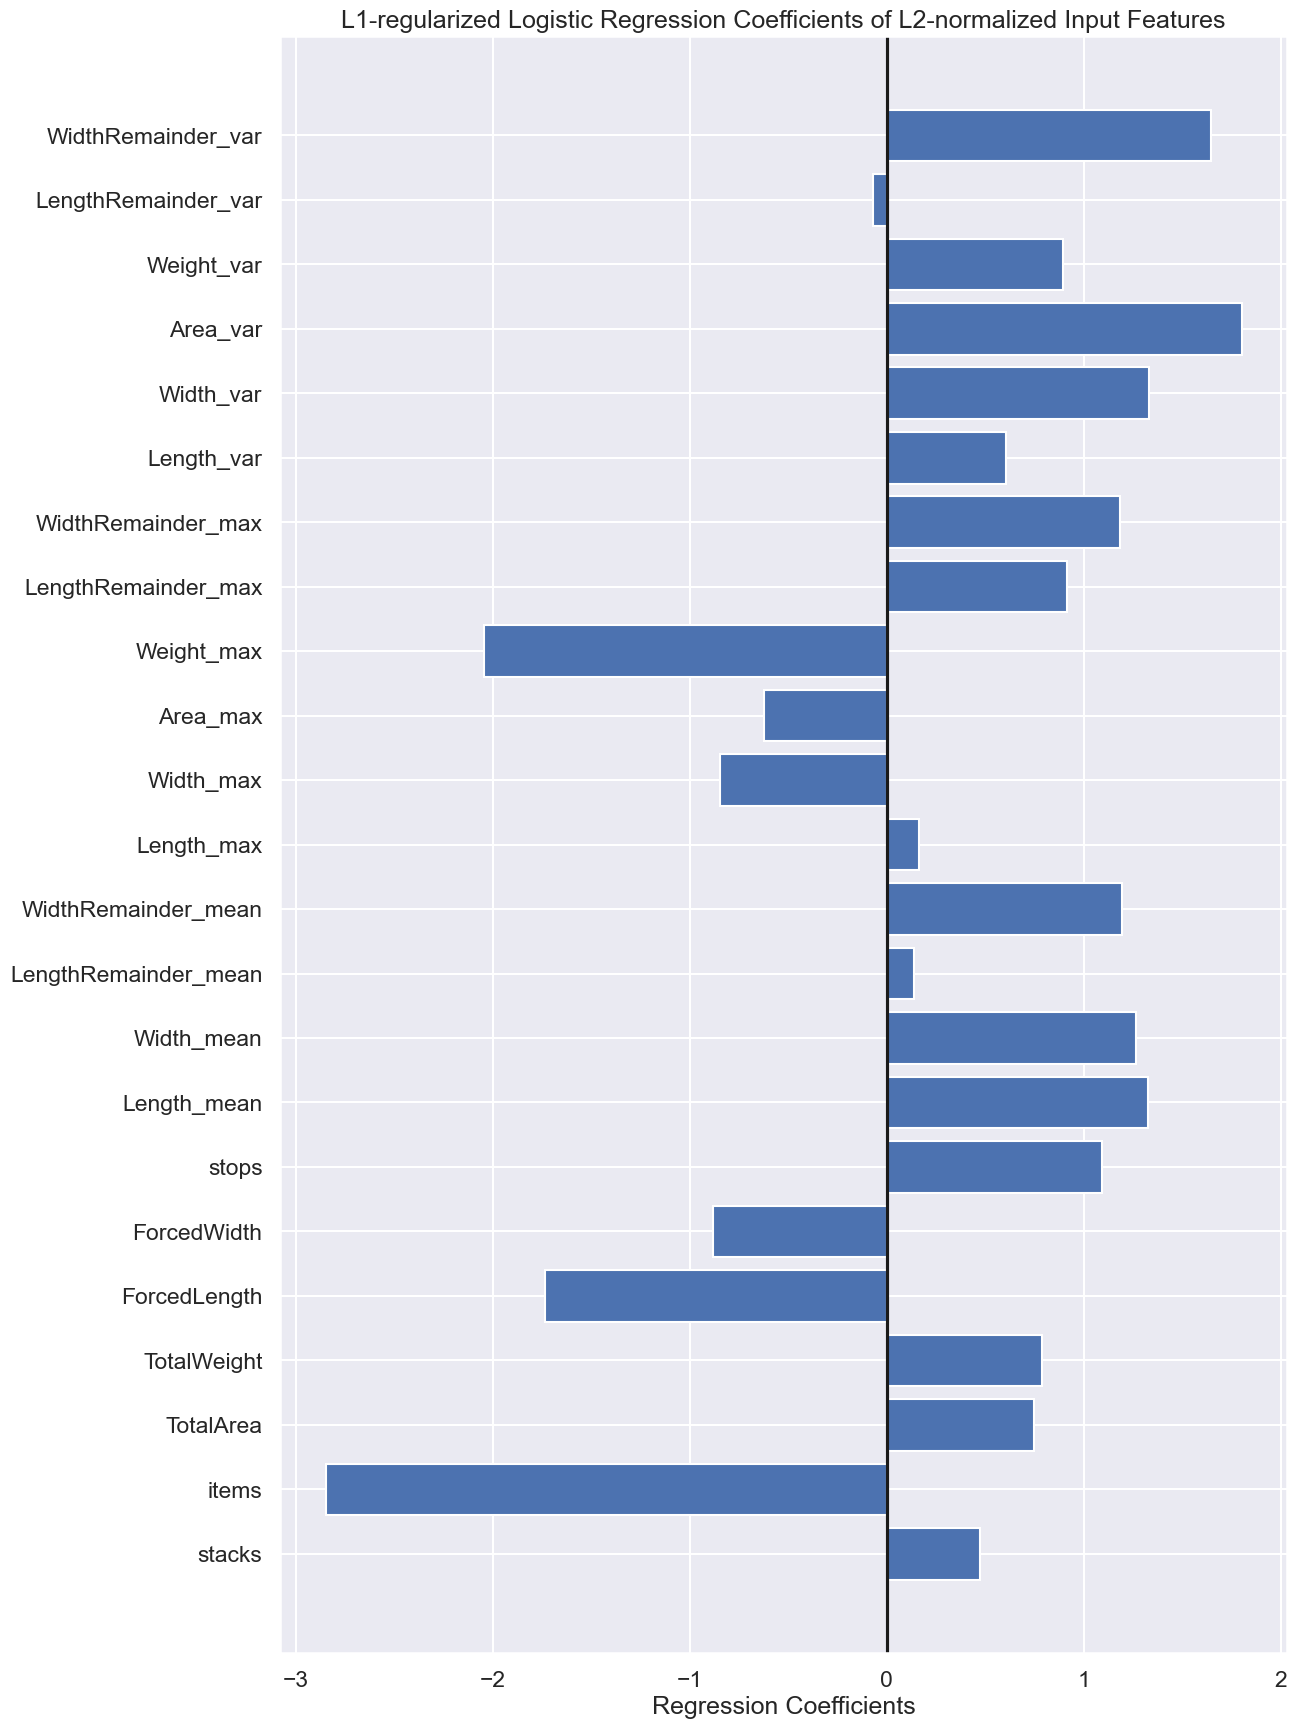

In [53]:
clf = rscv.best_estimator_[-1]
plt.figure(figsize = (13, 21))
plt.barh(rscv.best_estimator_[:-1].get_feature_names_out(), clf.coef_[0]);


plt.axvline(0, c="k");
plt.title("L1-regularized Logistic Regression Coefficients of L2-normalized Input Features");
plt.xlabel("Regression Coefficients");

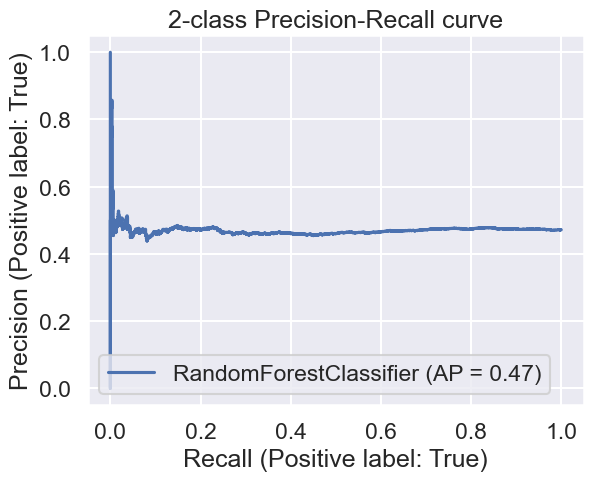

In [54]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    rscv.best_estimator_, X_test, y_test, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# with duplicates: 83%

### RandomForest:

In [55]:
from sklearn.ensemble import RandomForestClassifier


pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    RandomForestClassifier(n_estimators = 50)
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test).round(3)

# with duplicates:
# 0.988

0.5

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, poisson, geom



param_dist = {
    #"pca__n_components": ["passthrough"] + list(range(10, X.shape[1])),
    #"normalizer__norm": ["passthrough", "l1", "l2", "max"],
    "randomforestclassifier__n_estimators": poisson(50, loc = 10),
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": poisson(7, loc = 1),
    "randomforestclassifier__min_samples_split": poisson(6, loc = 2),
    "randomforestclassifier__min_samples_leaf": poisson(6, loc = 1),
    "randomforestclassifier__max_features": ["sqrt", "log2"]
}

rscv = RandomizedSearchCV(pipe, param_dist, n_iter = 24, cv = 3,
                          scoring = "average_precision",
                          n_jobs = 8)

rscv.fit(X_train, y_train)

y_pred = rscv.best_estimator_.predict(X_train)
print("training scores:")
print("-"* 53)
print(classification_report(y_train, y_pred, digits = 3))

print("")

print("testing scores:")
print("-"* 53)
y_pred = rscv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits = 3)) # rows: labs; clms: pred

training scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.566     0.952     0.710      3520
        True      0.772     0.182     0.295      3146

    accuracy                          0.589      6666
   macro avg      0.669     0.567     0.502      6666
weighted avg      0.663     0.589     0.514      6666


testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.532     0.906     0.670      1761
        True      0.504     0.107     0.177      1573

    accuracy                          0.529      3334
   macro avg      0.518     0.507     0.424      3334
weighted avg      0.519     0.529     0.438      3334



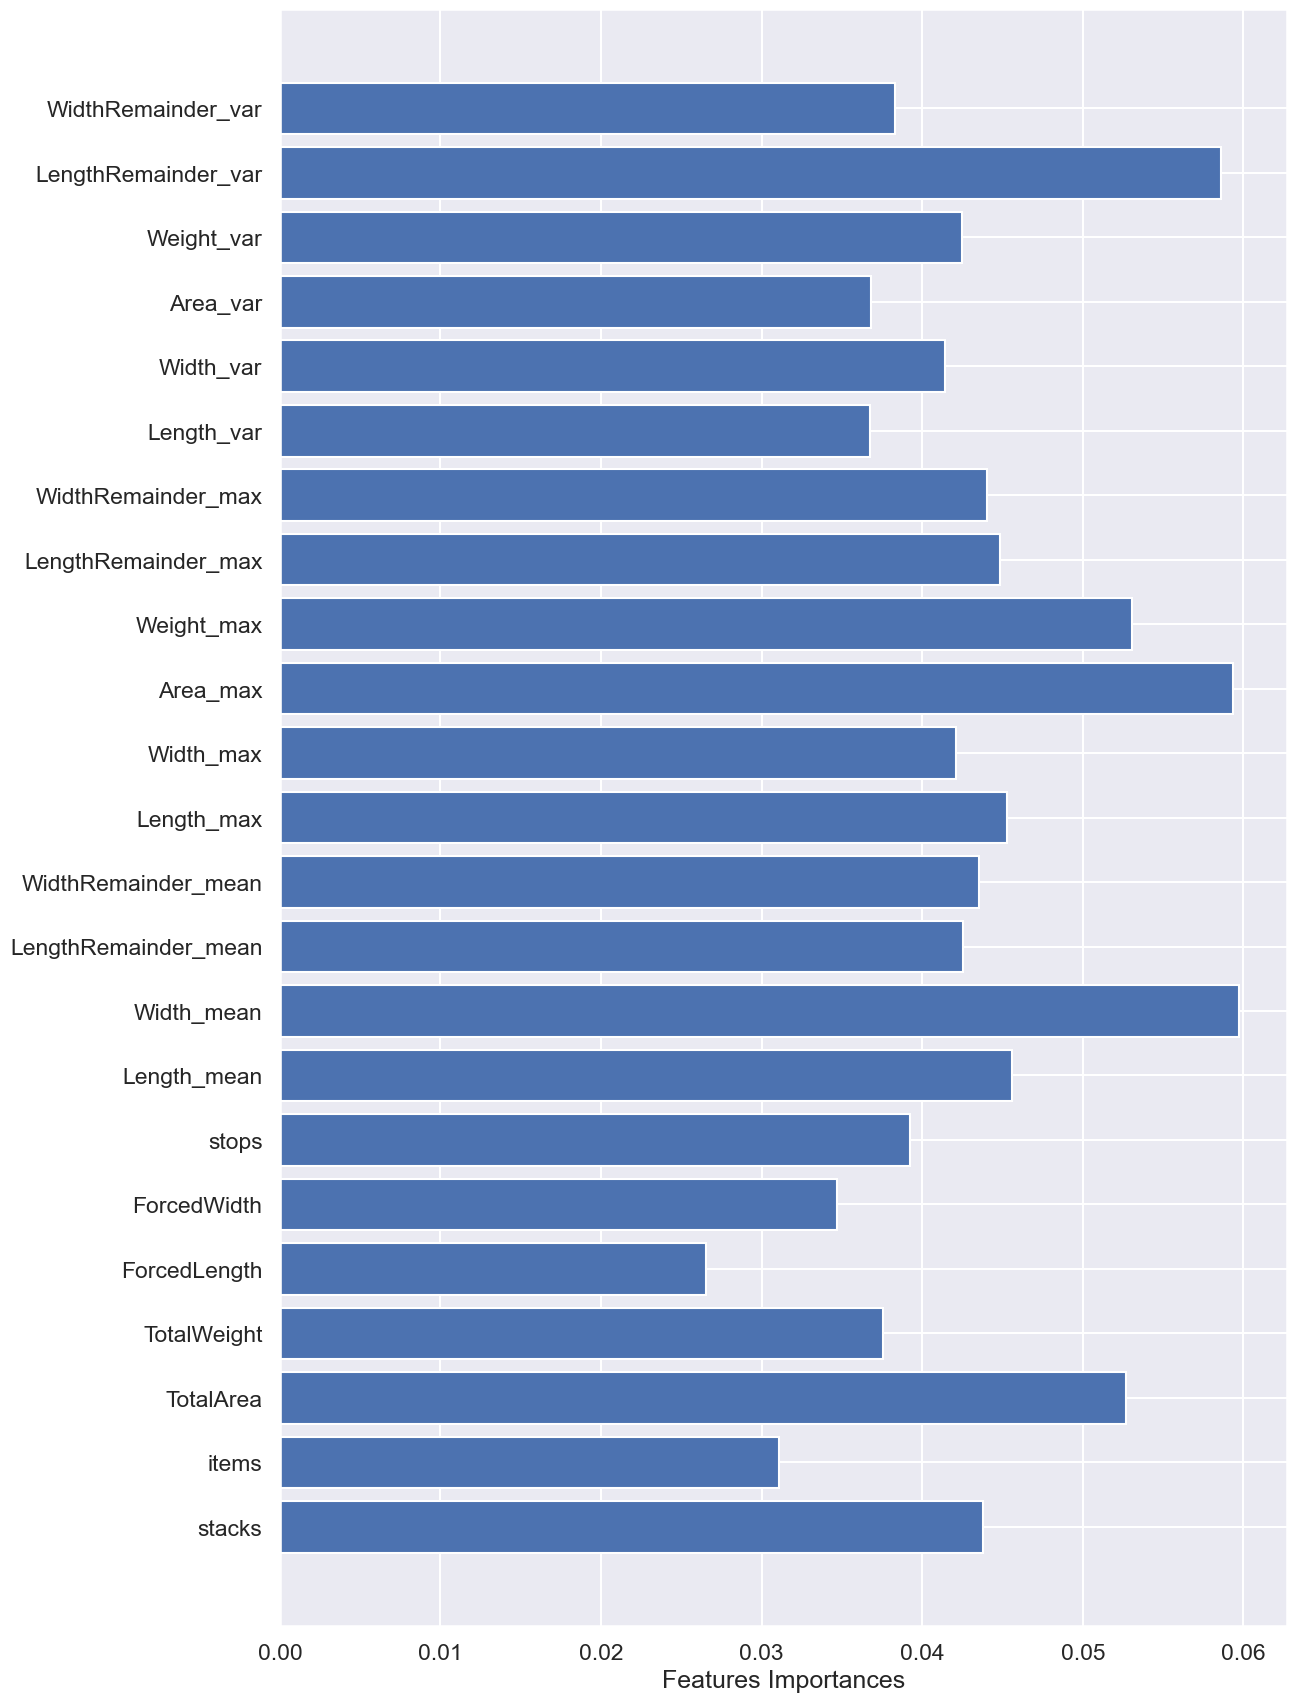

In [57]:
clf = rscv.best_estimator_["randomforestclassifier"]
plt.figure(figsize = (13, 21))

if len(rscv.best_estimator_) > 1:
    clms = rscv.best_estimator_[:-1].get_feature_names_out()
else:
    clms = X.columns

plt.barh(clms, clf.feature_importances_);
plt.xlabel("Features Importances");

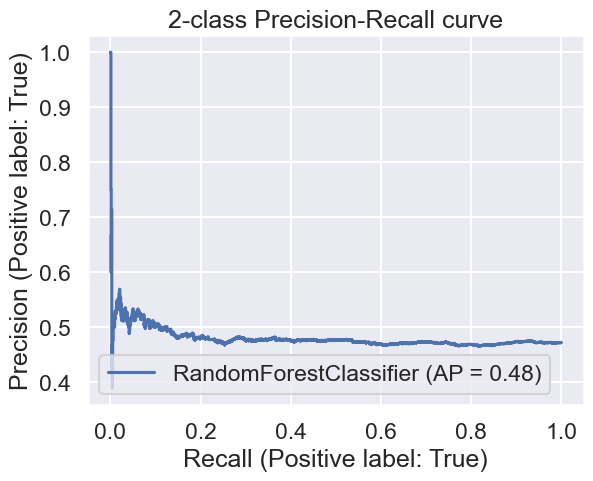

In [58]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    rscv.best_estimator_, X_test, y_test, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### SVC:

In [59]:
from sklearn.svm import SVC


pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    SVC(kernel="rbf", probability=True)
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test).round(3)

# with duplicates:
# 0.988#

0.516

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, poisson, geom



param_dist = {
    #"pca__n_components": ["passthrough"] + list(range(10, X.shape[1])),
    #"normalizer__norm": ["passthrough", "l1", "l2", "max"],
    "svc__C": expon(1),
    "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svc__degree": [1, 2, 3],
    "svc__gamma": ["scale", "auto"],
    "svc__class_weight": [None, "balanced"]
}

rscv = RandomizedSearchCV(pipe, param_dist, n_iter = 24, cv = 3,
                          scoring = "average_precision",
                          n_jobs = 8)

rscv.fit(X_train, y_train)

y_pred = rscv.best_estimator_.predict(X_train)
print("training scores:")
print("-"* 53)
print(classification_report(y_train, y_pred, digits = 3))

print("")

print("testing scores:")
print("-"* 53)
y_pred = rscv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits = 3)) # rows: labs; clms: pred

training scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.520     0.520     0.520      3520
        True      0.464     0.464     0.464      3146

    accuracy                          0.494      6666
   macro avg      0.492     0.492     0.492      6666
weighted avg      0.494     0.494     0.494      6666


testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.525     0.546     0.535      1761
        True      0.467     0.446     0.457      1573

    accuracy                          0.499      3334
   macro avg      0.496     0.496     0.496      3334
weighted avg      0.498     0.499     0.498      3334



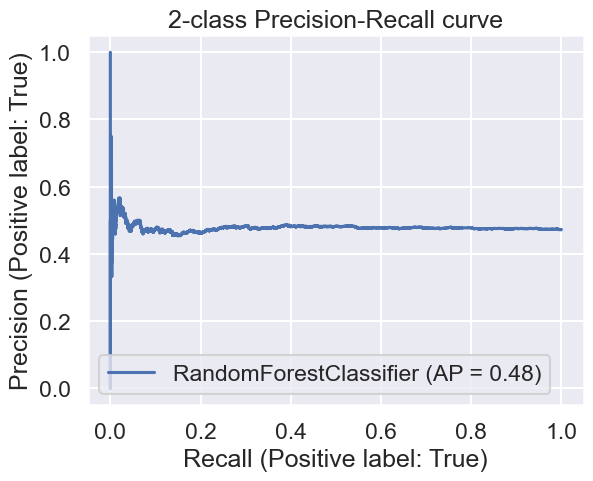

In [61]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    rscv.best_estimator_, X_test, y_test, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    KNeighborsClassifier()
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test).round(3)

# with duplicates:
# 0.988#

0.513

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, poisson, geom



param_dist = {
    #"pca__n_components": ["passthrough"] + list(range(10, X.shape[1])),
    #"normalizer__norm": ["passthrough", "l1", "l2", "max"],
    "kneighborsclassifier__n_neighbors": poisson(7),
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__p": poisson(1, loc=1),
}

rscv = RandomizedSearchCV(pipe, param_dist, n_iter = 24, cv = 3,
                          scoring = "average_precision",
                          n_jobs = 8)

rscv.fit(X_train, y_train)

y_pred = rscv.best_estimator_.predict(X_train)
print("training scores:")
print("-"* 53)
print(classification_report(y_train, y_pred, digits = 3))

print("")

print("testing scores:")
print("-"* 53)
y_pred = rscv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits = 3)) # rows: labs; clms: pred

training scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.645     0.697     0.670      3520
        True      0.627     0.570     0.597      3146

    accuracy                          0.637      6666
   macro avg      0.636     0.634     0.634      6666
weighted avg      0.636     0.637     0.636      6666


testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.529     0.581     0.554      1761
        True      0.473     0.421     0.445      1573

    accuracy                          0.506      3334
   macro avg      0.501     0.501     0.500      3334
weighted avg      0.503     0.506     0.503      3334



In [64]:
rscv.best_params_

{'kneighborsclassifier__n_neighbors': 9,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'uniform'}

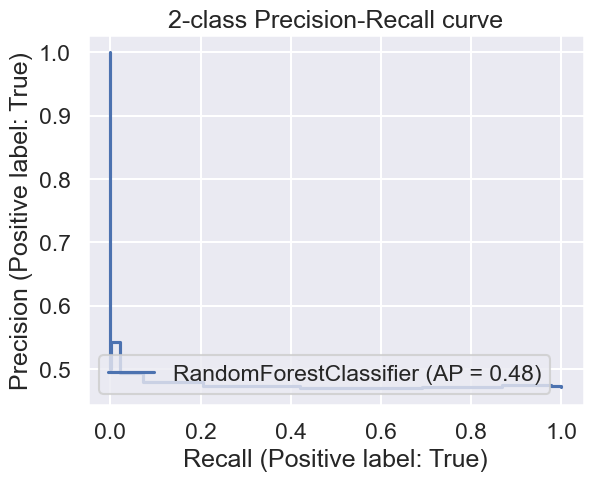

In [65]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    rscv.best_estimator_, X_test, y_test, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Gaussian NB

In [66]:
from sklearn.naive_bayes import GaussianNB

pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    GaussianNB()
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test).round(3)

# with duplicates:
# 0.988#

0.508

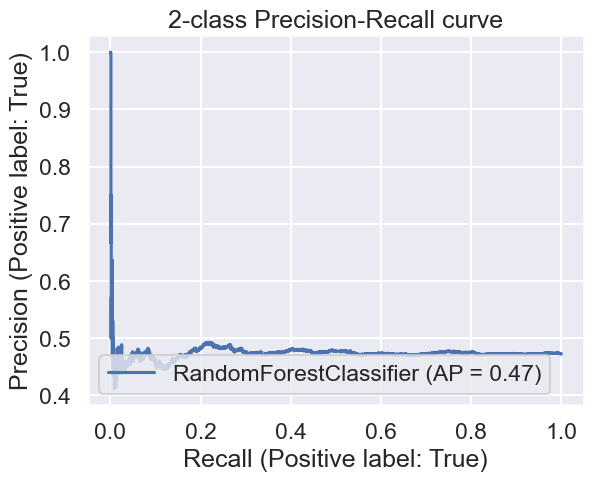

In [67]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    pipe, X_test, y_test, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")